## **Conformal Prediction using Energy Hospital Load**

One example of the NP data is the electricity consumption of a hospital in SF. It has hourly reservation for the entire year of 2015.

### Extract Data and Split Data into Train, Val, Cal, and Test


**Extract Data From GitHub**

In [1]:
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
file = 'energy/SF_hospital_load.csv'
# file = 'air_passengers.csv'

In [3]:
data_df = pd.read_csv(data_location + file)

In [4]:
# data_df.head(5)

In [5]:
# data_df.tail(5)

**Split data into train, val, cal, and test in that order**

Do we need to instantiate a NP model `m` in order to split the df into train and test? If so, does the NP params make any diff to the outcome of this split? I'm presuming no atm.

In [6]:
m = NeuralProphet()

In [7]:
train_df, test_df = m.split_df(data_df, freq='H', valid_p = 1.0/16)
# train_df, cal_df = m.split_df(train_df, freq='H', valid_p = 1.0/11)
# train_df, val_df = m.split_df(train_df, freq='H', valid_p = 1.0/10)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [8]:
train_df.shape, test_df.shape

((8213, 2), (547, 2))

In [9]:
print(f"Train set time range:        {train_df['ds'].min()} - {train_df['ds'].max()}")
# print(f"Validation set time range:   {val_df['ds'].min()} - {val_df['ds'].max()}")
# print(f"Calibration set time range:  {cal_df['ds'].min()} - {cal_df['ds'].max()}")
print(f"Test set time range:         {test_df['ds'].min()} - {test_df['ds'].max()}")

Train set time range:        2015-01-01 01:00:00 - 2015-12-09 05:00:00
Test set time range:         2015-12-09 06:00:00 - 2016-01-01 00:00:00


### Create Folds using CV Splits

In [10]:
freq = "H"
B = 20  # bootstrapped models B, recommended [20-50]
fold_pct = 0.04  # <= 0.04
fold_overlap_pct = 0.  # 0
# METRICS = ['SmoothL1Loss', 'MAE', 'RMSE']
# params = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}

In [11]:
folds = NeuralProphet().crossvalidation_split_df(
    train_df,
    freq=freq,
    k=B,
    fold_pct=fold_pct,
    fold_overlap_pct=fold_overlap_pct
)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


In [12]:
train_df
train_df.ds.min(), train_df.ds.max()

(Timestamp('2015-01-01 01:00:00'), Timestamp('2015-12-09 05:00:00'))

In [13]:
# for i, (train_df, cal_df) in enumerate(folds):
#     print(f"Fold {i+1}:")
#     print(f"  - Train start: {train_df.ds.min()}, Train end: {train_df.ds.max()}")
#     print(f"  - Cal start:   {cal_df.ds.min()}, Cal end:   {cal_df.ds.max()}")

### Train the NP Models (with 5th/95th Quantiles)
- `m1`: NP with default features
- `m2`: NP with parametric time-based features (like in Facebook Prophet)
- `m3`: NP with 1-layer AR
- `m4`: NP with 4-layer deep AR

In [14]:
# quantile_lo, quantile_hi = 0.05, 0.95
# quantiles = [quantile_lo, quantile_hi]
# n_lags = 3*24

In [15]:
# m1 = NeuralProphet(
#     quantiles=quantiles,
# )
# m2 = NeuralProphet(
#     weekly_seasonality=6,
#     daily_seasonality=10,
#     trend_reg=1,
#     learning_rate=0.01,
#     quantiles=quantiles,
# )
# m3 = NeuralProphet(
#     growth='off',
#     yearly_seasonality=False,
#     weekly_seasonality=False,
#     daily_seasonality=False,
#     n_lags=n_lags,
#     ar_reg=1,
#     learning_rate=0.01,
#     quantiles=quantiles,
# )
# m4 = NeuralProphet(
#     growth='off',
#     yearly_seasonality=False,
#     weekly_seasonality=False,
#     daily_seasonality=False,
#     n_lags=n_lags,
#     num_hidden_layers=4,
#     d_hidden=32,
#     learning_rate=0.003,
#     quantiles=quantiles,
# )

Train the 4 models. You can either concatonate the train and val set into one full training set or use the val set separately for hyperparameter tuning. I recommend trying both ways to see how to performance evaluation metrics change.

In [16]:
quantile_lo = 0.05
quantile_hi = 0.95
quantile_lo_str = str(quantile_lo*100)
quantile_hi_str = str(quantile_hi*100)
quantiles = [quantile_lo, quantile_hi]

params = {'quantiles': quantiles}

In [17]:
cols = ['y', 'yhat1', 'residual1', f'yhat1 {quantile_lo_str}%', f'yhat1 {quantile_hi_str}%']
all_forecast = pd.DataFrame(columns=cols)

In [18]:
%%time
for train_df, cal_df in folds:
    m = NeuralProphet(**params)
    metrics = m.fit(train_df, freq='H', minimal=True)
    forecast = m.predict(cal_df)
    all_forecast = pd.concat([all_forecast, forecast[cols]], ignore_index=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.94% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 167


  0%|          | 0/131 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([262, 1, 1])) that is different to the input size (torch.Size([262, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: 

  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.54E-02, min: 1.70E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.53E-02
Epoch[167/167]: 100%|██████████| 167/167 [00:24<00:00,  6.89it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.95% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


  0%|          | 0/132 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([264, 1, 1])) that is different to the input size (torch.Size([264, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: 

  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.04E-02, min: 1.30E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.33E-02
Epoch[158/158]: 100%|██████████| 158/158 [00:27<00:00,  5.65it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.957% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/134 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([268, 1, 1])) that is different to the input size (torch.Size([268, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: 

  0%|          | 0/134 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.71E-02, min: 6.83E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.41E-02
Epoch[151/151]: 100%|██████████| 151/151 [00:30<00:00,  4.92it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.962% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/135 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([270, 1, 1])) that is different to the input size (torch.Size([270, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: 

  0%|          | 0/135 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.97E-02, min: 1.76E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.09E-02
Epoch[146/146]: 100%|██████████| 146/146 [00:33<00:00,  4.33it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/137 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([274, 1, 1])) that is different to the input size (torch.Size([274, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: 

  0%|          | 0/137 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.76E-02, min: 1.94E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.44E-02
Epoch[141/141]: 100%|██████████| 141/141 [00:36<00:00,  3.84it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.97% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


  0%|          | 0/138 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([276, 1, 1])) that is different to the input size (torch.Size([276, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: 

  0%|          | 0/138 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.17E-02, min: 1.74E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.74E-02
Epoch[137/137]: 100%|██████████| 137/137 [00:36<00:00,  3.71it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/139 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([278, 1, 1])) that is different to the input size (torch.Size([278, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: 

  0%|          | 0/139 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.61E-02, min: 2.12E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.05E-02
Epoch[134/134]: 100%|██████████| 134/134 [00:39<00:00,  3.38it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.975% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([280, 1, 1])) that is different to the input size (torch.Size([280, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: 

  0%|          | 0/140 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.72E-02, min: 5.42E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.67E-02
Epoch[131/131]: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.977% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/141 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([282, 1, 1])) that is different to the input size (torch.Size([282, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: 

  0%|          | 0/141 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.54E-02, min: 1.10E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.91E-02
Epoch[128/128]: 100%|██████████| 128/128 [00:46<00:00,  2.75it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.978% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/141 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([282, 1, 1])) that is different to the input size (torch.Size([282, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.08E-02, min: 1.72E-01


  0%|          | 0/141 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.08E-02, min: 1.72E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.94E-02
Epoch[126/126]: 100%|██████████| 126/126 [00:48<00:00,  2.58it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.98% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


  0%|          | 0/142 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([284, 1, 1])) that is different to the input size (torch.Size([284, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.14E-02, min: 8.63E-02


  0%|          | 0/142 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.14E-02, min: 8.63E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.55E-02
Epoch[123/123]: 100%|██████████| 123/123 [00:51<00:00,  2.40it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/143 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([286, 1, 1])) that is different to the input size (torch.Size([286, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.86E-02, min: 2.18E-01


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.06E-02, min: 1.63E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.67E-02
Epoch[121/121]: 100%|██████████| 121/121 [00:54<00:00,  2.21it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/143 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([286, 1, 1])) that is different to the input size (torch.Size([286, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.06E-02, min: 1.88E-01


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.37E-02, min: 1.88E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.05E-02
Epoch[119/119]: 100%|██████████| 119/119 [00:56<00:00,  2.10it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/144 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([288, 1, 1])) that is different to the input size (torch.Size([288, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.34E-02, min: 9.53E-02


  0%|          | 0/144 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.62E-02, min: 9.53E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.27E-02
Epoch[118/118]: 100%|██████████| 118/118 [00:57<00:00,  2.04it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/145 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([290, 1, 1])) that is different to the input size (torch.Size([290, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.22E-02, min: 1.15E-01


  0%|          | 0/145 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.22E-02, min: 1.15E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.62E-02
Epoch[116/116]: 100%|██████████| 116/116 [01:00<00:00,  1.93it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/145 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([290, 1, 1])) that is different to the input size (torch.Size([290, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.49E-02, min: 1.54E-01


  0%|          | 0/145 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.49E-02, min: 1.54E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.50E-02
Epoch[114/114]: 100%|██████████| 114/114 [01:03<00:00,  1.80it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/146 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([292, 1, 1])) that is different to the input size (torch.Size([292, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.13E-02, min: 2.14E-01


  0%|          | 0/146 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 1.86E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.72E-02
Epoch[113/113]: 100%|██████████| 113/113 [01:05<00:00,  1.73it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/146 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([292, 1, 1])) that is different to the input size (torch.Size([292, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 4.38E-01


  0%|          | 0/146 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 3.29E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.05E-02
Epoch[112/112]: 100%|██████████| 112/112 [01:08<00:00,  1.63it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/147 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([294, 1, 1])) that is different to the input size (torch.Size([294, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.07E-02, min: 4.55E-01


  0%|          | 0/147 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.07E-02, min: 1.46E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.49E-02
Epoch[110/110]: 100%|██████████| 110/110 [01:11<00:00,  1.54it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/147 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([294, 1, 1])) that is different to the input size (torch.Size([294, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.41E-02, min: 5.24E-01


  0%|          | 0/147 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.41E-02, min: 4.55E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.64E-02
Epoch[109/109]: 100%|██████████| 109/109 [01:11<00:00,  1.52it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


CPU times: user 17min 6s, sys: 1.91 s, total: 17min 8s
Wall time: 17min 7s


In [19]:
alpha = 0.1
method = 'naive'

In [20]:
naive_noncon_scores = np.abs(all_forecast['residual1'].values)
naive_noncon_scores = naive_noncon_scores[~pd.isnull(naive_noncon_scores)]  # remove NaN values
naive_noncon_scores.sort()
print(naive_noncon_scores.shape)

# get the q-hat index and value
naive_qhat_idx = int(len(naive_noncon_scores)*alpha)
naive_qhat = naive_noncon_scores[-naive_qhat_idx]
# naive_qhats.append(naive_qhat)

(6560,)


In [21]:
cqr_scoring_func = (
    lambda row: [None, None]
    if row[f"yhat1 {quantile_lo_str}%"] is None or row[f"yhat1 {quantile_hi_str}%"] is None
    else [
        max(row[f"yhat1 {quantile_lo_str}%"] - row["y"], row["y"] - row[f"yhat1 {quantile_hi_str}%"]),
        0 if row[f"yhat1 {quantile_lo_str}%"] - row["y"] > row["y"] - row[f"yhat1 {quantile_hi_str}%"] else 1,
    ]
)

cqr_scores_df = all_forecast.apply(cqr_scoring_func, axis=1, result_type="expand")
cqr_scores_df.columns = ["scores", "arg"]
cqr_noncon_scores = cqr_scores_df["scores"].values
cqr_noncon_scores = cqr_noncon_scores[~pd.isnull(cqr_noncon_scores)]  # remove NaN values
cqr_noncon_scores.sort()
print(cqr_noncon_scores.shape)

# get the q-hat index and value
cqr_qhat_idx = int(len(cqr_noncon_scores)*alpha)
cqr_qhat = cqr_noncon_scores[-cqr_qhat_idx]
# cqr_qhats.append(cqr_qhat)

(6560,)


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [23]:
def plot_nonconformity_scores(scores, q, method):
    plt.plot(scores, label="score")
    plt.axhline(y=q, color="r", linestyle="-", label=f"q1={round(q, 2)}")
    plt.xlabel("Sorted Index")
    plt.ylabel("Nonconformity Score")
    plt.title(f"{method} Nonconformity Score with q")
    plt.legend()
    plt.show();

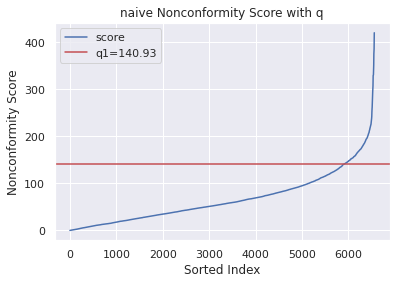

In [24]:
method = 'naive'
plot_nonconformity_scores(naive_noncon_scores, naive_qhat, method)

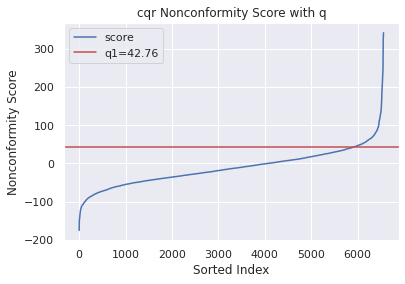

In [25]:
method = 'cqr'
plot_nonconformity_scores(cqr_noncon_scores, cqr_qhat, method)

Get forecasts and *naive* and *CQR* conformal prediction interval of OOS test_df

In [51]:
m.q_hats = [naive_qhat]
m.conformal_method = 'naive'
m.quantile_lo = None
m.quantile_hi = None
naive_forecast = m.predict(test_df)
naive_forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 - qhat1,yhat1 + qhat1
0,2015-12-09 06:00:00,803.410865,179.993249,983.404114,857.746582,1112.877686,1034.720215,-36.198177,-15.117934,842.476437,1124.331790
1,2015-12-09 07:00:00,868.264194,215.099210,1083.363403,939.715576,1215.220459,1034.744385,-44.453388,93.072464,942.435727,1224.291080
2,2015-12-09 08:00:00,975.752982,168.407418,1144.160400,1005.175476,1260.129883,1034.768433,-52.867008,162.258896,1003.232724,1285.088077
3,2015-12-09 09:00:00,983.268943,173.391336,1156.660278,1028.886719,1267.493774,1034.792603,-61.390854,183.258514,1015.732602,1297.587955
4,2015-12-09 10:00:00,1095.825986,52.337710,1148.163696,1024.032227,1264.082520,1034.816650,-69.974205,183.321259,1007.236020,1289.091373


In [52]:
cutoff = 7*24 # 0
x_size = 12
y_size = 6
figsize = (x_size, y_size)
plotting_backend = 'default'

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


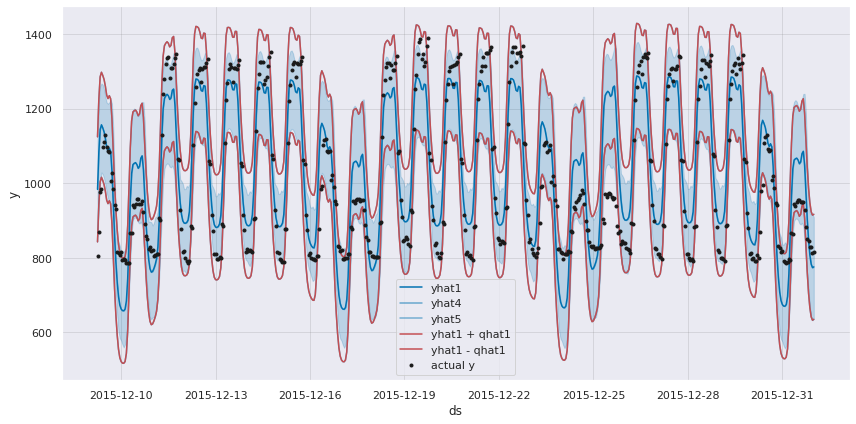

In [53]:
fig = m.highlight_nth_step_ahead_of_each_forecast(1) \
       .plot(naive_forecast, figsize=figsize, plotting_backend=plotting_backend)  # [-cutoff:]

In [54]:
m.q_hats = [cqr_qhat]
m.conformal_method = 'cqr'
m.quantile_lo = quantile_lo_str
m.quantile_hi = quantile_hi_str
cqr_forecast = m.predict(test_df)
cqr_forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
0,2015-12-09 06:00:00,803.410865,179.993249,983.404114,857.746582,1112.877686,1034.720215,-36.198177,-15.117934,1070.118584,1155.636787,814.987481,900.505683
1,2015-12-09 07:00:00,868.264194,215.099210,1083.363403,939.715576,1215.220459,1034.744385,-44.453388,93.072464,1172.461358,1257.979560,896.956475,982.474677
2,2015-12-09 08:00:00,975.752982,168.407418,1144.160400,1005.175476,1260.129883,1034.768433,-52.867008,162.258896,1217.370782,1302.888984,962.416375,1047.934577
3,2015-12-09 09:00:00,983.268943,173.391336,1156.660278,1028.886719,1267.493774,1034.792603,-61.390854,183.258514,1224.734673,1310.252876,986.127617,1071.645820
4,2015-12-09 10:00:00,1095.825986,52.337710,1148.163696,1024.032227,1264.082520,1034.816650,-69.974205,183.321259,1221.323418,1306.841621,981.273125,1066.791328


WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


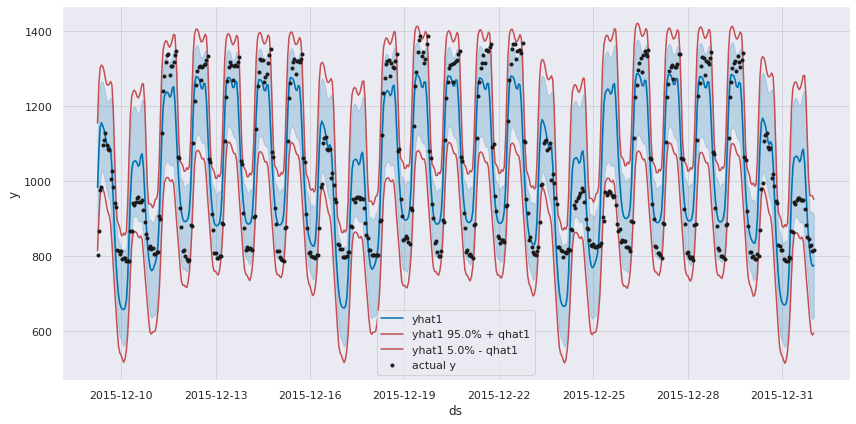

In [55]:
fig = m.highlight_nth_step_ahead_of_each_forecast(1) \
       .plot(cqr_forecast, figsize=figsize, plotting_backend=plotting_backend)  # [-cutoff:]

### Evaluate Performance

- **interval_width**: The average prediction interval, or q_hat multiplied by 2 because it is static or non-adaptive. Also the *efficiency* metric.
- **miscoverage_rate**: The actual miscoverage error rate on the OOS test set. Also the *validity* metric.

For the both metrics, the lower the number, the better the performance.



In [56]:
conformal_methods = ['enbpi_tscv', 'enbcqr_tscv']
eval_df = pd.DataFrame(columns=pd.MultiIndex.from_product([conformal_methods, ['interval_width','miscoverage_rate']]))
eval_df = eval_df.reset_index().rename(columns={'index': 'model'})

Enter in the model names

In [57]:
eval_df['model'] = ['m1']

Enter in the **interval_width** (*efficiency* metric)

In [58]:
# Naive interval width
naive_iw = [naive_qhat*2]
eval_df['enbpi_tscv', 'interval_width'] = naive_iw

In [59]:
# Calculate CQR interval width function
def calc_cqr_iw(fcast_df, qr_lo, qr_hi, qhat):
    qr_lo_mean = fcast_df['yhat1'].mean() - fcast_df[f'yhat1 {qr_lo}%'].mean()
    qr_hi_mean = fcast_df[f'yhat1 {qr_hi}%'].mean() - fcast_df['yhat1'].mean()
    return qr_lo_mean + qr_hi_mean + qhat*2

In [60]:
# CQR interval width
cqr_iw = calc_cqr_iw(cqr_forecast, quantile_lo_str, quantile_hi_str, cqr_qhat)
# cqr_iw1 = calc_cqr_iw(cqr_forecast1, quantile_lo_str, quantile_hi_str, cqr_qhat1)
# cqr_iw2 = calc_cqr_iw(cqr_forecast2, quantile_lo_str, quantile_hi_str, cqr_qhat2)
# cqr_iw3 = calc_cqr_iw(cqr_forecast3, quantile_lo_str, quantile_hi_str, cqr_qhat3)
# cqr_iw4 = calc_cqr_iw(cqr_forecast4, quantile_lo_str, quantile_hi_str, cqr_qhat4)

cqr_iw = [cqr_iw]
# cqr_iw = [cqr_iw1, cqr_iw2, cqr_iw3, cqr_iw4]
eval_df['enbcqr_tscv', 'interval_width'] = cqr_iw

In [61]:
# Calculate CQR Advanced interval width function
# def calc_cqr_adv_iw(fcast_df, qr_lo, qr_hi, qhat_lo, qhat_hi):
#     qr_lo_mean = fcast_df['yhat1'].mean() - fcast_df[f'yhat1 {qr_lo}%'].mean()
#     qr_hi_mean = fcast_df[f'yhat1 {qr_hi}%'].mean() - fcast_df['yhat1'].mean()
#     return qr_lo_mean + qr_hi_mean + qhat_lo + qhat_hi

In [62]:
# CQR Advanced interval width
# cqr_adv_iw1 = calc_cqr_adv_iw(cqr_adv_forecast1, quantile_lo_str, quantile_hi_str, cqr_lo_qhat1, cqr_hi_qhat1)
# cqr_adv_iw2 = calc_cqr_adv_iw(cqr_adv_forecast2, quantile_lo_str, quantile_hi_str, cqr_lo_qhat2, cqr_hi_qhat2)
# cqr_adv_iw3 = calc_cqr_adv_iw(cqr_adv_forecast3, quantile_lo_str, quantile_hi_str, cqr_lo_qhat3, cqr_hi_qhat3)
# cqr_adv_iw4 = calc_cqr_adv_iw(cqr_adv_forecast4, quantile_lo_str, quantile_hi_str, cqr_lo_qhat4, cqr_hi_qhat4)

# cqr_adv_iw = [cqr_adv_iw1, cqr_adv_iw2, cqr_adv_iw3, cqr_adv_iw4]
# eval_df['cqr_adv', 'interval_width'] = cqr_adv_iw

Enter in the **miscoverage rate** (*validity* metric)

In [63]:
# Calculate Naive miscoverage rate function
def calc_naive_mr(fcast_df):
    n_covered = fcast_df.apply(lambda row: bool(row['yhat1 - qhat1'] <= row['y'] <= row['yhat1 + qhat1']), axis=1)
    coverage_rate = n_covered.sum() / len(fcast_df)
    return 1 - coverage_rate

In [64]:
# Naive miscoverage rate
naive_mr = calc_naive_mr(naive_forecast)
# naive_mr1 = calc_naive_mr(naive_forecast1)
# naive_mr2 = calc_naive_mr(naive_forecast2)
# naive_mr3 = calc_naive_mr(naive_forecast3)
# naive_mr4 = calc_naive_mr(naive_forecast4)

naive_mr = [naive_mr]
# naive_mr = [naive_mr1, naive_mr2, naive_mr3, naive_mr4]]
eval_df['enbpi_tscv', 'miscoverage_rate'] = naive_mr

In [65]:
# Calculate CQR and CQR Advanced miscoverage rate function
def calc_cqr_mr(fcast_df, qr_lo, qr_hi):
    n_covered = fcast_df.apply(lambda row: bool(row[f'yhat1 {qr_lo}% - qhat1'] <= row['y'] <= row[f'yhat1 {qr_hi}% + qhat1']), axis=1)
    coverage_rate = n_covered.sum() / len(fcast_df)
    return 1 - coverage_rate

In [66]:
# CQR miscoverage rate
cqr_mr = calc_cqr_mr(cqr_forecast, quantile_lo_str, quantile_hi_str)
# cqr_mr1 = calc_cqr_mr(cqr_forecast1, quantile_lo_str, quantile_hi_str)
# cqr_mr2 = calc_cqr_mr(cqr_forecast2, quantile_lo_str, quantile_hi_str)
# cqr_mr3 = calc_cqr_mr(cqr_forecast3, quantile_lo_str, quantile_hi_str)
# cqr_mr4 = calc_cqr_mr(cqr_forecast4, quantile_lo_str, quantile_hi_str)

cqr_mr = [cqr_mr]
# cqr_mr = [cqr_mr1, cqr_mr2, cqr_mr3, cqr_mr4]
eval_df['enbcqr_tscv', 'miscoverage_rate'] = cqr_mr

In [67]:
# CQR Advanced miscoverage rate
# cqr_adv_mr1 = calc_cqr_mr(cqr_adv_forecast1, quantile_lo_str, quantile_hi_str)
# cqr_adv_mr2 = calc_cqr_mr(cqr_adv_forecast2, quantile_lo_str, quantile_hi_str)
# cqr_adv_mr3 = calc_cqr_mr(cqr_adv_forecast3, quantile_lo_str, quantile_hi_str)
# cqr_adv_mr4 = calc_cqr_mr(cqr_adv_forecast4, quantile_lo_str, quantile_hi_str)

# cqr_adv_mr = [cqr_adv_mr1, cqr_adv_mr2, cqr_adv_mr3, cqr_adv_mr4]
# eval_df['cqr_adv', 'miscoverage_rate'] = cqr_adv_mr

Show evaluation dataframe

In [68]:
eval_df

model     enbpi_tscv                     enbcqr_tscv                 
        interval_width miscoverage_rate interval_width miscoverage_rate
0    m1     281.855353         0.131627     334.412273         0.067642

**Summary**: 

CQR outputs narrower prediction *interval width* than Naive while maintaining slightly better *miscoverage rate* (for the advanced AR models m4 and m4). The complex m4 model performs the best for *interval_width* while the simple m1 performs the best for actual *miscoverage rate*, hovering around *alpha*. However, that is because it has also by far the highest *interval_width*. m3 and m4 models have actual *miscoverage rates* are roughly twice the amount as the intended *alpha* of 0.1, which is consistent with the conformal prediction literature.